In [1]:
# Imports
# !pip install torchmetrics
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.models import MobileNet_V2_Weights
from torchmetrics.classification import BinaryConfusionMatrix
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
from tqdm.notebook import tqdm
import tempfile
import shutil
import random
from sklearn.model_selection import KFold

mount drive if running in google colab


In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

print("In Colab: {}".format(IN_COLAB))

if IN_COLAB:
    from image_utils import get_sample_image_size
    from csv_utils import split_classes, how_many, split_classes_threshold
    from file_utils import train_test_split, num_images
    from google.colab import drive

    drive.mount("/content/gdrive")

else:
    import sys

    sys.path.append("..")
    from src.utils.image_utils import get_sample_image_size
    from src.utils.csv_utils import split_classes, how_many, split_classes_threshold
    from src.utils.file_utils import train_test_split, num_images

In Colab: False


set computation device to gpu if available


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}")

Computation device: cpu


set seed for reproducibility


In [4]:
torch.manual_seed(0)
random.seed(0)

Set HyperParameters


In [5]:
EPOCHS = 15
BATCH = 64
# FOLDS = 5

# percent of all data to go towards testing and validation
# TRACKS_PER_CLASS = 500
PERCENT_TESTING = 0.15
PERCENT_VALIDATION = 0.15
LEARNING_RATE = 0.001

# spectrogram parameters
RESOLUTION = "high"  # low or high
TRACK_DURATION = 30  # 15 or 31

# popularity thresholds
# TRACKS_PER_CLASS = 1000
HIGH_THRESHOLD = 500000
LOW_THRESHOLD = 500000

Initialize Model


In [8]:
# load the model
model_name = "MobileNet-v2"
weights = 'MobileNet_V2_Weights.IMAGENET1K_V2'
model = models.mobilenet_v2(
    weights=MobileNet_V2_Weights.IMAGENET1K_V2).to(device)
# model = models.mobilenet_v2(weights = None).to(device)
# model = models.alexnet(pretrained=True).to(device)
# print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

#### load the train and test data


In [9]:
# Setting paths
base_path = f"../data" if not IN_COLAB else f"/content/gdrive/MyDrive/AI-Project/data"
dir_name = f"ch_{RESOLUTION}_{TRACK_DURATION}_all"
spectrograms_path = f"{base_path}/spectrograms/{dir_name}"
csv_path = f"{base_path}/audio_features.csv"
df = pd.read_csv(csv_path)

print(f"Csv Length: {len(df)}")
print(f"Number of spectrograms: {num_images(spectrograms_path)}")

num_viral = how_many(csv_path, "number_of_videos", HIGH_THRESHOLD, "above")
num_not_viral = how_many(csv_path, "number_of_videos", LOW_THRESHOLD, "below")

print(f"Number of tracks above threshold: {num_viral}")
print(f"Number of tracks below threshold: {num_not_viral}")

Csv Length: 3932
Number of spectrograms: 3915
Number of tracks above threshold: 1416
Number of tracks below threshold: 2516


All images should be the same size but we resize them according to the first image just to be safe.


In [10]:
image_size = get_sample_image_size(spectrograms_path)
HEIGHT, WIDTH = image_size[0], image_size[1]
print(f"height: {image_size[0]}, width: {image_size[1]}")

Number of channels in the image: 1
height: 128, width: 646


In [11]:
transform = transforms.Compose(
    [
        transforms.Resize((HEIGHT, WIDTH)),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)


def get_datasets():
    # create temporary folder to store spectrograms
    root_dir = "../data/temp" if not IN_COLAB else "./temp"
    os.makedirs(root_dir, exist_ok=True)
    temp_dir = tempfile.mkdtemp(dir=root_dir)

    # split into two classes based on popularity thresholds
    out_path = f"{temp_dir}/"
    # split_classes(
    #     csv_path, spectrograms_path, out_path, ["viral", "notviral"], TRACKS_PER_CLASS
    # )
    split_classes_threshold(
        csv_path,
        spectrograms_path,
        out_path,
        ["viral", "notviral"],
        HIGH_THRESHOLD,
        LOW_THRESHOLD,
    )

    # copy spectrograms to temporary folder split into train and test directories
    data_dir = tempfile.mkdtemp(prefix=dir_name + "_", dir=root_dir)
    print(f"Data directory: {data_dir}")
    train_dir, test_dir = train_test_split(temp_dir, data_dir, PERCENT_TESTING)
    train_dataset = ImageFolder(train_dir, transform=transform)
    test_dataset = ImageFolder(test_dir, transform=transform)

    # delete temporary folder
    shutil.rmtree(temp_dir)
    return train_dataset, test_dataset, data_dir

In [12]:
train_dataset, test_dataset, data_dir = get_datasets()

print(f"number of training images: {len(train_dataset)}")
print(f"number of testing images: {len(test_dataset)}")

Number of files in viral: 1410
Number of files in notviral: 2505
Data directory: ../data/temp/ch_high_30_all_6qxfxlip
Number of images per class: [2505, 1410]
Number of testing images per class: [375, 211]
Processing class: notviral
Created subdirectories: ../data/temp/ch_high_30_all_6qxfxlip/training/notviral and ../data/temp/ch_high_30_all_6qxfxlip/testing/notviral
Processing class: viral
Created subdirectories: ../data/temp/ch_high_30_all_6qxfxlip/training/viral and ../data/temp/ch_high_30_all_6qxfxlip/testing/viral
number of training images: 3329
number of testing images: 586


#### Looking at the dataset


In [13]:
img, label = train_dataset[0]
print(img.shape, label)
print("classes : \n", train_dataset.classes)

# num images per class
print("num images per class")
print(train_dataset.targets.count(0))
print(train_dataset.targets.count(1))

torch.Size([3, 128, 646]) 0
classes : 
 ['notviral', 'viral']
num images per class
2130
1199


display the first image in the dataset


Label : notviral


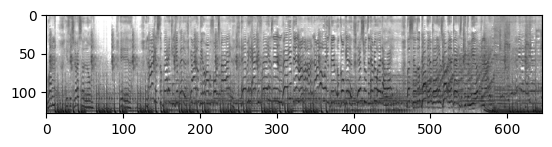

In [14]:
def display_img(img, label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))


display_img(*train_dataset[0])

load the train and validation into batches.


In [15]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

val_size = int(len(train_dataset) * PERCENT_VALIDATION)
train_size = len(train_dataset) - val_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

# train_dl = DataLoader(train_data, BATCH, shuffle = True, num_workers = 4, pin_memory = True)
# val_dl = DataLoader(val_data, BATCH*2, num_workers = 4, pin_memory = True)

train_dl = DataLoader(train_data, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_data, batch_size=BATCH)
test_dl = DataLoader(test_dataset, batch_size=BATCH)

Length of Train Data : 2830
Length of Validation Data : 499


visualize a single batch of images


In [16]:
from torchvision.utils import make_grid


def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


# show_batch(train_dl)

initializing confusion matrix


In [17]:
bcm = BinaryConfusionMatrix()

Function for training (one epoch)


In [21]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    cum_loss = 0.0
    cum_correct = 0

    for i, (x, y) in tqdm(enumerate(trainloader), total=len(trainloader), desc="Training"):

        (x, y) = (x.to(device), y.to(device))
        pred = model(x)

        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()
        cum_correct += (pred.argmax(1) == y).sum().item()

    epoch_acc = cum_correct / len(trainloader.dataset)
    epoch_loss = cum_loss / len(trainloader)
    return epoch_acc, epoch_loss

Function for testing (one epoch)


In [19]:
def test(model, testloader, criterion):
    model.eval()
    cum_loss = 0.0
    cum_correct = 0

    with torch.no_grad():
        for x, y in tqdm(testloader, total=len(testloader), desc="Testing"):
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)

            loss = criterion(pred, y)
            cum_loss += loss
            cum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    epoch_acc = cum_correct / len(testloader.dataset)
    epoch_loss = cum_loss / len(testloader)
    return epoch_acc, epoch_loss

Training and testing the model:


In [22]:
# dictionary to keep track of losses and accuracies
H = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

# train the model
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_acc, train_epoch_loss = train(
        model, train_dl, optimizer, criterion
    )
    test_epoch_acc, test_epoch_loss = test(model, test_dl, criterion)

    # print all the metrics
    print(
        f"Train loss: {train_epoch_loss:.4f} | Train acc: {train_epoch_acc:.4f}")
    print(f"Test loss: {test_epoch_loss:.4f} | Test acc: {test_epoch_acc:.4f}")
    H["train_loss"].append(train_epoch_loss)
    H["train_acc"].append(train_epoch_acc)
    H["test_loss"].append(test_epoch_loss)
    H["test_acc"].append(test_epoch_acc)

Epoch 1 of 15


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 6.6604 | Train acc: 0.0081
Test loss: 7.0757 | Test acc: 0.0000
Epoch 2 of 15


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 5.6656 | Train acc: 0.1350
Test loss: 5.4019 | Test acc: 0.2509
Epoch 3 of 15


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 4.6840 | Train acc: 0.4081
Test loss: 4.3963 | Test acc: 0.5119
Epoch 4 of 15


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 3.7491 | Train acc: 0.5852
Test loss: 3.4286 | Test acc: 0.6109
Epoch 5 of 15


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 2.9529 | Train acc: 0.6244
Test loss: 3.3280 | Test acc: 0.6229
Epoch 6 of 15


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 2.3552 | Train acc: 0.6339
Test loss: 3.3001 | Test acc: 0.6297
Epoch 7 of 15


Training:   0%|          | 0/45 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
metric = BinaryConfusionMatrix()
model.eval()

for i, (x, y) in enumerate(train_dl):
  # if i==2:
    # break
  (x, y) = (x.to(device), y.to(device))
  pred = model(x).to(device)
  metric.update(pred[:,1], y)

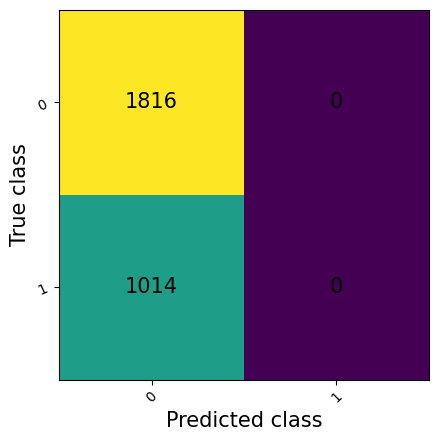

In [ ]:
fig, ax = metric.plot()

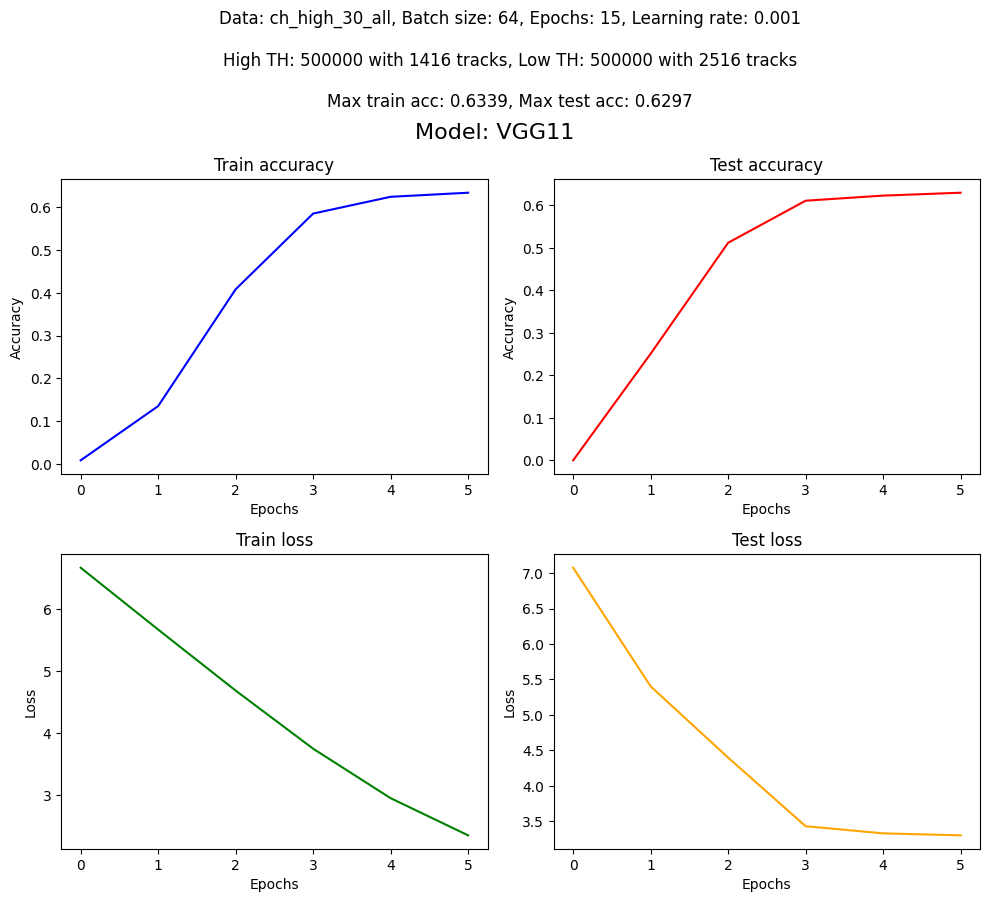

In [24]:
max_train_acc = max(H["train_acc"])
max_test_acc = max(H["test_acc"])
# model_name = 'VGG11'

fig = plt.figure(figsize=(10, 8))
# supertitle
fig.suptitle(f"Model: {model_name}", fontsize=16)
info = f"""Data: {dir_name}, Batch size: {BATCH}, Epochs: {EPOCHS}, Learning rate: {LEARNING_RATE}\n
High TH: {HIGH_THRESHOLD} with {num_viral} tracks, Low TH: {LOW_THRESHOLD} with {num_not_viral} tracks\n
Max train acc: {max_train_acc:.4f}, Max test acc: {max_test_acc:.4f}"""
fig.text(0.515, 1, info, ha="center", fontsize=12)


sub1 = fig.add_subplot(221)
sub1.set_title("Train accuracy")
sub1.plot(H["train_acc"], color="blue", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

sub2 = fig.add_subplot(222)
sub2.set_title("Test accuracy")
sub2.plot(H["test_acc"], color="red", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

sub3 = fig.add_subplot(223)
sub3.set_title("Train loss")
sub3.plot(H["train_loss"], color="green", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")


sub4 = fig.add_subplot(224)
sub4.set_title("Test loss")
sub4.plot([l.item() for l in H["test_loss"]], color="orange", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()